In [121]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
# Afficher toutes les lignes du résultat
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [122]:
def maximimsation_marge(montant,status):
    taux_marge = 0.05
    if status == "TP":
        res = 0 # le fraudeur est détecté
    elif status == "TN":
        res = taux_marge * montant # un client honnête est accepté
    #elif status == "FP":
        #res = 0.7*taux_marge * montant # un client honnête est bloqué
        #res = -0.2*taux_marge * montant # on mets moins pour que çe pénalise + le systeme de detection
    elif status == "FN" or status == "FP" : # un fraudeur est accepté 
        if montant <= 20:
            res = 0
        elif montant <= 50:
            res = -0.2 * montant
        elif montant <= 100:
            res = -0.3 * montant
        elif montant <= 200:
            res = -0.5 * montant
        else:
            res = -0.8 * montant
    return res

In [123]:
def application_regles(y_test,y_pred):
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'status': "null"})
    for index, row in df.iterrows():
        if row['y_test'] == 1 and row['y_pred'] == 1:
            df.at[index, 'status'] = "TP"
        elif row['y_test'] == 0 and row['y_pred'] == 0:
            df.at[index, 'status'] = "TN"
        elif row['y_test'] == 0 and row['y_pred'] == 1:
            df.at[index, 'status'] = "FP"
        elif row['y_test'] == 1 and row['y_pred'] == 0:
            df.at[index, 'status'] = "FN"
    return df

In [124]:
methods = ["smote","undersampling"]

method = "undersampling"

df_train = pd.read_csv("../data/classif/"+method+"/dataframe_train.csv")
print(df_train.shape)


df_test = pd.read_csv("../data/classif/"+method+"/dataframe_test.csv")
print(df_test.shape)

(101495, 23)
(747411, 23)


In [125]:
df_train.head()

,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Jour,Mois,FlagImpaye,Cluster_Code_Decision
0,60.92,1,0,0,0,545.0,0.006986,11.305842,0.001252,50.500371,43.444766,0,1,4.0,4.0,4.0,60.92,0.0,38669,4,5,0,0
1,76.14,0,1,1,1,1.0,3.807000,-1.492390,0.863439,20.270270,33.024087,0,1,5.0,5.0,5.0,76.14,0.0,66509,17,5,0,0
2,50.99,1,0,0,0,547.0,0.000000,0.000000,0.000000,39.789501,33.546107,0,1,4.0,4.0,4.0,50.99,0.0,35585,18,3,0,0
3,70.13,0,1,1,1,1.0,0.000000,0.000000,0.000000,33.596564,33.546107,0,1,5.0,5.0,5.0,70.13,0.0,60571,8,4,0,0
4,70.13,0,1,1,1,1.0,0.000000,0.000000,0.000000,33.596564,33.546107,0,1,5.0,5.0,5.0,70.13,0.0,60571,8,4,0,0


In [126]:
col_to_drop = ["CodeDecision"]

df_train = df_train.drop(columns=col_to_drop)
df_test = df_test.drop(columns=col_to_drop)

In [127]:
df_train.corr()

,Montant,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Jour,Mois,FlagImpaye,Cluster_Code_Decision
Montant,1.000000,0.348517,0.342775,0.319863,-0.128787,0.586059,-0.114183,0.315421,0.037306,0.067421,0.018204,0.084795,-0.089906,-0.015606,0.023506,0.834209,0.350301,0.051884,0.006246,0.054272,0.334097,0.018996
VerifianceCPT1,0.348517,1.000000,0.887300,0.791164,-0.270788,0.114615,-0.145856,0.116466,0.031985,0.051300,0.026075,0.100416,-0.060882,0.081589,0.157361,0.287123,0.115950,0.094210,-0.005081,0.048370,0.291534,0.026631
VerifianceCPT2,0.342775,0.887300,1.000000,0.931307,-0.240632,0.117001,-0.162303,0.126661,0.026043,0.067112,0.048627,0.172565,-0.133558,0.004742,0.107259,0.325551,0.187343,0.075124,-0.003727,0.043846,0.297513,0.040453
VerifianceCPT3,0.319863,0.791164,0.931307,1.000000,-0.216518,0.101593,-0.165907,0.110072,0.021941,0.072301,0.044465,0.171475,-0.150783,-0.022613,0.071852,0.310969,0.187015,0.065553,-0.003109,0.039530,0.292653,0.037380
D2CB,-0.128787,-0.270788,-0.240632,-0.216518,1.000000,-0.109333,0.167801,-0.387232,-0.032104,-0.001144,-0.008746,-0.039607,-0.373758,-0.623213,-0.743062,-0.114100,-0.056434,-0.215121,-0.050732,-0.211242,-0.094760,-0.008347
ScoringFP1,0.586059,0.114615,0.117001,0.101593,-0.109333,1.000000,-0.023309,0.518055,0.016148,0.015392,0.007324,0.024060,0.007472,0.071771,0.097735,0.483998,0.196979,0.015433,0.004907,0.030318,0.105952,0.006215
ScoringFP2,-0.114183,-0.145856,-0.162303,-0.165907,0.167801,-0.023309,1.000000,-0.117773,0.006317,-0.126310,-0.014899,-0.095562,0.091934,0.010699,-0.038891,-0.119497,-0.081179,-0.176549,-0.025877,-0.088909,-0.278159,-0.010317
ScoringFP3,0.315421,0.116466,0.126661,0.110072,-0.387232,0.518055,-0.117773,1.000000,0.027792,0.021008,0.011872,0.015676,0.201776,0.361325,0.431418,0.231799,0.057282,0.096608,0.018066,0.091161,0.063824,0.011196
TauxImpNb_RB,0.037306,0.031985,0.026043,0.021941,-0.032104,0.016148,0.006317,0.027792,1.000000,0.028960,0.001175,0.001779,0.002404,0.019173,0.025560,0.031974,0.014517,-0.001149,0.004814,-0.003475,0.090237,0.002685
TauxImpNB_CPM,0.067421,0.051300,0.067112,0.072301,-0.001144,0.015392,-0.126310,0.021008,0.028960,1.000000,0.008570,0.029720,-0.118075,-0.084872,-0.066718,0.064878,0.038284,0.014910,-0.001409,0.025195,0.218112,0.011284


In [128]:
target = 'FlagImpaye'
predictors = ['Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB', 'ScoringFP1', 'TauxImpNb_RB', 'EcartNumCheq', 'NbrMagasin3J', 'DiffDateTr1', 'DiffDateTr2',
        'DiffDateTr3', 'CA3TRetMtt', 'CA3TR', 'Heure', 'Jour', 'Mois', 'Cluster_Code_Decision']

In [129]:
import xgboost as xgb

# # test
# clf = DecisionTreeClassifier(max_depth=5, random_state=0)
# clf.fit(df_train[predictors], df_train[target].values)
# preds = clf.predict(df_test[predictors])

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.01, n_estimators=100)

# Train the model
xgb_model.fit(df_train[predictors], df_train[target].values)

# Make predictions on the test set
y_pred = xgb_model.predict(df_test[predictors])

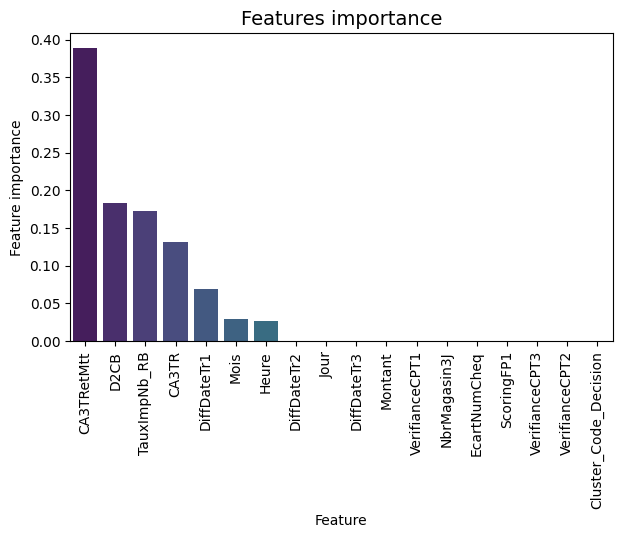

In [130]:
### Feature Importance 

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp,palette = 'viridis')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(df_test[target] , y_pred)
precision = precision_score(df_test[target] , y_pred)
recall = recall_score(df_test[target] , y_pred)
f1 = f1_score(df_test[target], y_pred, average='weighted')

new_row = {'accuracy':accuracy , 'precision':precision,'recall':recall ,'f1': f1 }
print(new_row)

{'accuracy': 0.726850420986579, 'precision': 0.015597418899305692, 'recall': 0.4839494903392667, 'f1': 0.833907917116642}


<Figure size 1000x500 with 0 Axes>

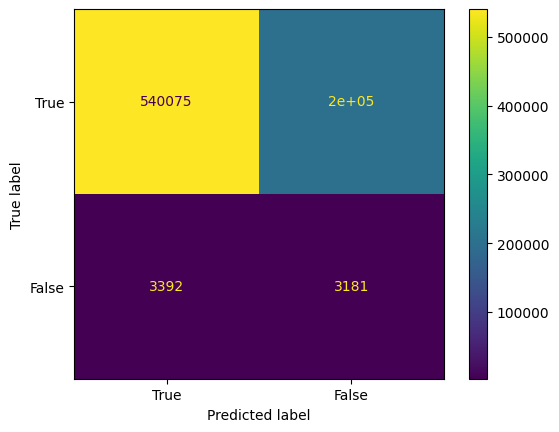

In [132]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


conf_mat = confusion_matrix(df_test[target], y_pred)
disp = ConfusionMatrixDisplay(conf_mat,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()
plt.show()

# GRID SEARCH OPTIMISATION MARGE

In [133]:
def scorer_marge(y_true, y_pred, X_train):
    df_res = application_regles(y_true, y_pred)
    total_marge = 0
    
    for row in df_res.itertuples():
        montant = X_train.at[row.Index, 'Montant']  # Accéder au montant pour chaque ligne
        total_marge += maximimsation_marge(montant, row.status)
    
    return total_marge

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


X_train = df_train.drop(columns=["FlagImpaye"])
y_train = df_train["FlagImpaye"]

# Définir le classificateur RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Définir les paramètres que vous souhaitez tester dans la recherche de grille
param_grid = {
    'n_estimators': [3,5,10,50,100],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [10,15,20, 25,40]
}

scorer = make_scorer(scorer_marge, X_train=X_train ,greater_is_better = True)

# Créer la grille de recherche avec votre fonction personnalisée comme mesure d'évaluation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=3, n_jobs=-1)

# Effectuer la recherche de grille
grid_search.fit(X_train, y_train)


# Afficher les résultats
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur marge  : ", grid_search.best_score_)

Meilleurs paramètres :  {'max_depth': 20, 'min_samples_leaf': 40, 'n_estimators': 100}
Meilleur marge  :  10876.845466666584


# INITIALISATION

In [135]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score 
import pickle


X_train = df_train.drop(['FlagImpaye'], axis=1)
y_train = df_train['FlagImpaye']

X_test = df_test.drop(['FlagImpaye'], axis=1)
y_test = df_test['FlagImpaye']


class_weights = {0: 1.0, 1: 10.0}  

# CROSS VALIDATION IMPOSSIBLE CAR TIMES SERIES
# METTRE UN TIME SERIES DANS LE GRID SEARCH

# Modèles
models = {

    # kernel approximation : RBFSampler ??

    # class_weight=class_weight 
        
    'Decision Tree': DecisionTreeClassifier(random_state=42,class_weight=class_weights),
    'Random Forest': RandomForestClassifier(criterion="gini",min_samples_split=100,class_weight=class_weights,random_state=42),
    'xgb model': xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.01, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42),
    'Neural Network': MLPClassifier(random_state=42),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(penalty='l2',random_state=42)
}


# TRAINING

In [136]:
for model_name, model in models.items():
    
    model.fit(X_train, y_train)
    print(model_name, " fitted")

    # save models
    filename = '../models/'+method+"/"+ model_name + '.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

Decision Tree  fitted


# LOAD MODELS & PREDICT (overfitting avec smote ????)

In [137]:
# Initialiser un DataFrame pour stocker les résultats
f1_df = pd.DataFrame(index=[method], columns=models.keys())
marge_df = pd.DataFrame(index=[method], columns=models.keys())

loaded_models = {}
for model_name in models.keys():
    filename = '../models/'+method+"/"+ model_name + '.pkl'
    with open(filename, 'rb') as file:
        loaded_models[model_name] = pickle.load(file)

# Test chaque modèle
for model_name, model in loaded_models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_df.at[method, model_name] = f1

        
    df_res = application_regles(y_test,y_pred)
    for row in df_res.itertuples():
        df_res.at[row.Index, 'marge'] = maximimsation_marge(X_test.at[row.Index, 'Montant'],row.status)

    
    total_marge = df_res['marge'].sum()
    marge_df.at[method  , model_name] = total_marge

    print("\ F1 score de ",model_name," sur l'ensemble de test :", f1)
    print("\ Marge de ",model_name," sur l'ensemble de test :", total_marge)
    print(confusion_matrix(y_test, y_pred))

\ F1 score de  Decision Tree  sur l'ensemble de test : 0.6879611394083732
\ Marge de  Decision Tree  sur l'ensemble de test : 1103828.6404999997
[[394698 346140]
 [  2174   4399]]


# Marge 

In [138]:
marge_df.to_csv('../data/'+method+'/marge.csv')
marge_df.head()

,Decision Tree
undersampling,1103828.6405


# F1 Score

In [139]:
f1_df.to_csv('../data/'+method+'/f1_df.csv')
f1_df.head()

,Decision Tree
undersampling,0.687961


In [140]:
df_train["FlagImpaye"].value_counts()

FlagImpaye
0    78073
1    23422
Name: count, dtype: int64

In [141]:
df_test["FlagImpaye"].value_counts()

FlagImpaye
0    740838
1      6573
Name: count, dtype: int64

In [142]:
# optimisation de la marge
#  donner la marge maximale (si modèle hypothétiquement parfait) et comparer avec la meilleure marge obtenue, du genre 'on a perdu 10% de marge par rapport au modèle parfait'